SIFT(Scale Invariant Feature Transformation) METHOD

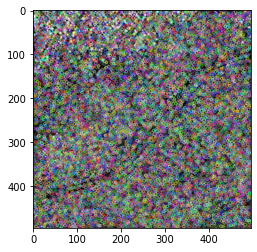

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

#reading image
img1 = cv2.imread('path-1.png')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)


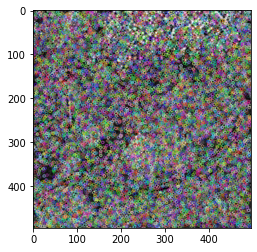

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

#reading image
img1 = cv2.imread('path-2.png')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)


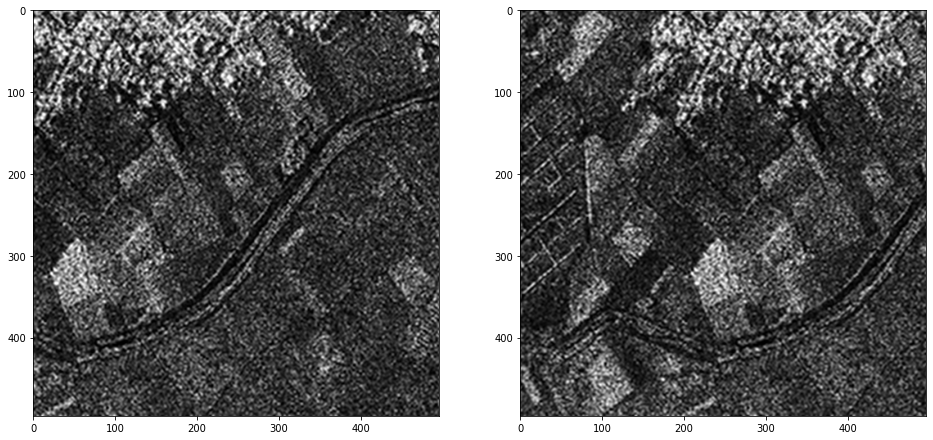

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('path-1.png')  
img2 = cv2.imread('path-2.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('path-1.png')  
img2 = cv2.imread('path-2.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

len(keypoints_1), len(keypoints_2)

(12778, 12212)

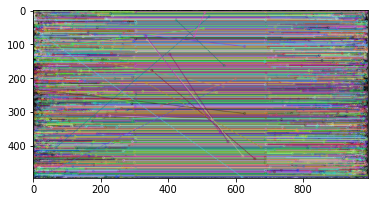

7305

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('path-1.png')  
img2 = cv2.imread('path-2.png') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
counted = len(bf.match(descriptors_1,descriptors_2))
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:6250], img2, flags=2)
plt.imshow(img3),plt.show()
counted

SAR-SIFT METHOD

In [ ]:
# -*- coding: utf-8 -*-
"""
@author: Administrator
"""
import __future__	
import numpy as np
import cv2
import scipy.ndimage
import math

def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.float64(np.exp(-((x**2 + y**2)/(2.0*sigma**2))))
    return g/g.sum()
    
def build_scale(image, sigma, Mmax, ratio, d):
    M,N = image.shape
    sar_harris_function = np.zeros((M,N,Mmax))
    gradient = np.zeros((M, N, Mmax))
    angle = np.zeros((M, N, Mmax))
    
    for i in range(Mmax):
        scale = float(sigma*ratio**(i))
        radius = int(round(2*scale))
        j = list(range(-radius,radius+1,1))
        k = list(range(-radius,radius+1,1))
        xarry,yarry = np.meshgrid(j,k)
        W = np.exp(-(np.abs(xarry)+np.abs(yarry))/scale)
        W34 = np.zeros((2*radius+1,2*radius+1),dtype=float)
        W12 = np.zeros((2*radius+1,2*radius+1),dtype=float)
        W14 = np.zeros((2*radius+1,2*radius+1),dtype=float)
        W23 = np.zeros((2*radius+1,2*radius+1),dtype=float)
        
        W34[radius+1:2*radius+1,:] = W[radius+1:2*radius+1,:]
        W12[0:radius,:] = W[0:radius,:]
        W14[:,radius+1:2*radius+1] = W[:,radius+1:2*radius+1]
        W23[:,0:radius] = W[:,0:radius]

        M34 = scipy.ndimage.correlate(image, W34, mode='nearest')
        M12 = scipy.ndimage.correlate(image, W12, mode='nearest')
        M14 = scipy.ndimage.correlate(image, W14, mode='nearest')
        M23 = scipy.ndimage.correlate(image, W23, mode='nearest')
        
        Gx = np.log(M14/M23)
        Gy = np.log(M34/M12)
        
        Gx[np.where(np.imag(Gx))] = np.abs(Gx[np.where(np.imag(Gx))])
        Gy[np.where(np.imag(Gy))] = np.abs(Gy[np.where(np.imag(Gy))])
        Gx[np.where(np.isfinite(Gx)==0)] = 0
        Gy[np.where(np.isfinite(Gy)==0)] = 0
           
        gradient[:,:,i] = np.sqrt(np.square(Gx)+np.square(Gy))
        temp_angle = np.arctan2(Gy, Gx)
        
        temp_angle = temp_angle/math.pi*180
        temp_angle[np.where(temp_angle<0)] = temp_angle[np.where(temp_angle<0)]+360
        angle[:,:,i] = temp_angle
        
        Csh_11 = scale**2 * np.square(Gx)
        Csh_12 = scale**2 * Gx*Gy
        Csh_22 = scale**2 * np.square(Gy)
        
        gaussian_sigma = math.sqrt(2)*scale
        width = round(3*gaussian_sigma)
        width_windows = int(2*width+1)
        W_gaussian = fspecial_gauss(width_windows,gaussian_sigma)
        
        l = list(range(0,width_windows,1))
        m = list(range(0,width_windows,1))
        a,b = np.meshgrid(l,m)
        index0,index1 = np.where((np.square(a-width)-1)+np.square(b-width- 1)>width**2)
        W_gaussian[index0,index1] = 0
        
        Csh_11 = scipy.ndimage.correlate(Csh_11, W_gaussian, mode='nearest')
        Csh_12 = scipy.ndimage.correlate(Csh_12, W_gaussian, mode='nearest')
        Csh_21 = Csh_12
        Csh_22 = scipy.ndimage.correlate(Csh_22, W_gaussian, mode='nearest')
        
        sar_harris_function[:,:,i] = Csh_11*Csh_22-Csh_21*Csh_12-d*(Csh_11+Csh_22)**2
        
    return sar_harris_function,gradient,angle
    

In [ ]:
# -*- coding: utf-8 -*-
"""
@author: Administrator
"""
import __future__
import numpy as np
import math
def calculate_oritation_hist(x,y,scale,gradient,angle,n):
    M,N = gradient.shape
    radius = int(round(min(6*scale,min(M/2,N/2))))
    sigma = 2*scale
    radius_x_left = x-radius
    radius_x_right = x+radius+1
    radius_y_up = y-radius
    radius_y_down = y+radius+1
    
    if radius_x_left <0:
        radius_x_left = 0
    if radius_x_right>=N:
        radius_x_right = N
    if radius_y_up <0:
        radius_y_up = 0
    if radius_y_down >= M:
        radius_y_down = M
        
    center_x = x-radius_x_left 
    center_y = y-radius_y_up 
    
    sub_gradient = gradient[radius_y_up:radius_y_down,radius_x_left:radius_x_right]
    sub_angle = angle[radius_y_up:radius_y_down,radius_x_left:radius_x_right]
    
    #X = list(range(-(x-radius_x_left),radius_x_right-x,1)) 
    #Y = list(range(-(y-radius_y_up),radius_y_down-y,1))
    #[XX,YY] = np.meshgrid(X,Y)
    W = sub_gradient
    bins = np.round(sub_angle*n/360.)
    
    bins[bins>=n] = bins[bins>=n]-n
    bins[bins<0] = bins[bins<0]+n

    tem_hist = np.zeros((n,1))
    row,col = bins.shape

    for i in range(row):
        for j in range(col):
            if (i-center_y)**2+(j-center_x)**2 <=radius**2:
                tem_hist[int(bins[i,j])] = tem_hist[int(bins[i,j])] + W[i,j]

    

#smooth histogram
    hist = np.zeros((n,1))
    hist[0] = (tem_hist[34] + tem_hist[2])/16. + 4*(tem_hist[35]+tem_hist[1])/16. + tem_hist[0]*6/16. 
    hist[1] = (tem_hist[35] + tem_hist[3])/16. + 4*(tem_hist[0]+tem_hist[2])/16. + tem_hist[1]*6/16.
    hist[2:n-2] = (tem_hist[0:n-4] + tem_hist[4:n])/16. + 4*(tem_hist[1:n-3]+tem_hist[3:n-1])/16. + tem_hist[2:n-2]*6/16.
    hist[n-2] = (tem_hist[n-4] + tem_hist[0])/16. + 4*(tem_hist[n-3]+tem_hist[n-1])/16. + tem_hist[1]*6/16.
    hist[n-1] = (tem_hist[n-3] + tem_hist[1])/16. + 4*(tem_hist[n-1]+tem_hist[0])/16. + tem_hist[n-1]*6/16.
    
    max_value = np.amax(hist)
    
    return hist,max_value

if __name__ == '__main__':
    a = np.ones((20,20))
    b = np.ones((20,20))
    m,n = calculate_oritation_hist(18,4,2,a,b,36)



    

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import numpy as np
import math

# import calculate_oritation_hist

def find_scale_extreme(sar_harris_function,threshold,sigma,ratio,gradient,angle):
    M,N,num = sar_harris_function.shape
    BORDER_WIDTH = 1
    HIST_BIN = 36
    SIFT_ORI__PEAK_RATIO = 0.8
    key_number = 0
    key_point_array = np.zeros((M*N,num-2))
    for i in range(num):
        temp_current = sar_harris_function[:,:,i]
        gradient_current = gradient[:,:,i]
        angle_current = angle[:,:,i]
        for j in range(BORDER_WIDTH,M-BORDER_WIDTH,1):
            for k in range(BORDER_WIDTH,N-BORDER_WIDTH,1):
                temp = temp_current[j,k]
                if temp>threshold \
                   and temp>temp_current[j-1,k-1] and temp>temp_current[j-1,k] and temp>temp_current[j-1,k+1] \
                   and temp>temp_current[j,k-1] and temp>temp_current[j,k+1] \
                   and temp>temp_current[j+1,k-1] and temp>temp_current[j+1,k] and temp>temp_current[j+1,k+1] :
                       scale = sigma*ratio**(i+1)
                       hist,max_value = calculate_oritation_hist(k,j,scale,gradient_current,angle_current,HIST_BIN)
                       
                       mag_thr = max_value*SIFT_ORI__PEAK_RATIO
                       for kk in range(HIST_BIN):
                           if kk ==0:
                               k1=HIST_BIN-1
                           else:
                               k1 = kk-1
                           if kk==HIST_BIN-1:
                               k2 = 0
                           else:
                               k2 = kk+1
                           if hist[kk]>hist[k1] and hist[kk]>hist[k2] and hist[kk]>mag_thr:
                               bins = kk + 0.5*(hist[k1]-hist[k2])/float((hist[k1]+ hist[k2] - 2*hist[kk]))
                               if bins <0:
                                   bins = HIST_BIN+bins
                               elif bins>=HIST_BIN:
                                   bins = bins-HIST_BIN
                               key_number = key_number + 1    
                               key_point_array[key_number,0] = k
                               key_point_array[key_number,1] = j
                               key_point_array[key_number,2] = sigma*ratio**(i)
                               key_point_array[key_number,3] = i
                               key_point_array[key_number,4] = (360/float(HIST_BIN))*bins
                               key_point_array[key_number,5] = hist[kk]
    key_point_array = key_point_array[1:key_number,0:6]
    return key_point_array

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import numpy as np
import math
def calc_log_polar_descriptor(gradient,angle,x,y,scale,main_angle,d,n):
    
    cos_t = math.cos(-main_angle/180.*math.pi)
    sin_t = math.sin(-main_angle/180.*math.pi)
    
    M,N = gradient.shape
    radius = int(round(min(12*scale,min(M/2,N/2))))
    
    radius_x_left = x-radius
    radius_x_right = x+radius+1
    radius_y_up = y-radius
    radius_y_down = y+radius+1
    
    if radius_x_left <0:
        radius_x_left = 0
    if radius_x_right>=N:
        radius_x_right = N
    if radius_y_up <0:
        radius_y_up = 0
    if radius_y_down >= M:
        radius_y_down = M
    
    center_x = x-radius_x_left 
    center_y = y-radius_y_up 
    
    sub_gradient = gradient[radius_y_up:radius_y_down,radius_x_left:radius_x_right]
    sub_angle = angle[radius_y_up:radius_y_down,radius_x_left:radius_x_right]
    sub_angle = np.round((sub_angle-main_angle)*n/360)
    sub_angle[sub_angle<0] = sub_angle[sub_angle<0] + n
    sub_angle[sub_angle==0] = n

    X = list(range(-(x-radius_x_left),radius_x_right-x,1)) 
    Y = list(range(-(y-radius_y_up),radius_y_down-y,1))
    [XX,YY] = np.meshgrid(X,Y)
    c_rot = XX*cos_t - YY*sin_t
    r_rot = XX*sin_t + YY*cos_t
    
    log_angle = np.arctan2(r_rot,c_rot)
    log_angle = log_angle/math.pi*180.
    log_angle[log_angle<0] = log_angle[log_angle<0] +360
    np.seterr(divide='ignore')
    log_amplitude = np.log2(np.sqrt(np.square(c_rot)+np.square(r_rot)))
    
    log_angle = np.round(log_angle*d/360.)
    log_angle[log_angle<=0] = log_angle[log_angle<=0] + d
    log_angle[log_angle>d] = log_angle[log_angle>d] - d

    r1 = math.log(radius*0.25,2)
    r2 = math.log(radius*0.73,2)
    log_amplitude[log_amplitude<=r1] = 1   
    log_amplitude[(log_amplitude>r1) * (log_amplitude<=r2)] =2
    log_amplitude[log_amplitude>r2] = 3
    
    temp_hist = np.zeros(((2*d+1)*n,1))
    row,col = log_angle.shape
    
    for i in range(row):
        for j in range(col):
            if (i-center_y)**2+(j-center_x)**2 <=radius**2:
                angle_bin = log_angle[i,j]
                amplitude_bin = log_amplitude[i,j]
                bin_vertical = sub_angle[i,j]
                Mag = sub_gradient[i,j]
                
                if amplitude_bin==1:
                    temp_hist[int(bin_vertical)-1] =  temp_hist[int(bin_vertical)-1] + Mag
                else:
                    temp_hist[int(((amplitude_bin-2)*d+angle_bin-1)*n+bin_vertical+n)-1] = temp_hist[int(((amplitude_bin-2)*d+angle_bin-1)*n+bin_vertical+n)-1] + Mag
                
    temp_hist = temp_hist/np.sqrt(np.dot(temp_hist.T,temp_hist))
    temp_hist[temp_hist>0.2] = 0.2
    temp_hist = temp_hist/np.sqrt(np.dot(temp_hist.T,temp_hist))
    descriptor = temp_hist.reshape(-1)
    
    return descriptor
    

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import numpy as np
# import calc_log_polar_descriptor

def calc_descriptors(gradient,angle,key_point_array):
    circle_bin = 8
    LOG_DESC_HIST_BINS = 8
    
    M = key_point_array.shape[0]
    d = circle_bin
    n = LOG_DESC_HIST_BINS
    descriptors = np.zeros((M,(2*d+1)*n))
    locs = key_point_array
    
    for i in range(M):
        x = int(key_point_array[i,0])
        y = int(key_point_array[i,1])
        scale = key_point_array[i,2]
        layer = int(key_point_array[i,3])
        main_angle = key_point_array[i,4]
        current_gradient = gradient[:,:,layer]
        current_angle = angle[:,:,layer]
        descriptors[i,:] = calc_log_polar_descriptor(current_gradient,current_angle,x,y,scale,main_angle,d,n)
            
    return descriptors,locs

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import numpy as np
import cv2 


def des_distance(deep_des1,deep_des2):
    error = deep_des1-deep_des2
    RMSE = np.sqrt(np.sum(np.square(error),axis=1))/float(deep_des1.shape[0])
    
    return RMSE
    
def deep_match(kp1_location,kp2_location,deep_des1,deep_des2,ratio):
    deep_kp1 = []
    deep_kp2 = []
    for i in range(deep_des1.shape[0]):
        des = np.tile(deep_des1[i],(deep_des2.shape[0],1))
        error = des - deep_des2
        RMSE = np.sqrt(np.sum(np.square(error),axis=1)/float(error.shape[1]))
        small_index = np.argsort(RMSE, axis=0)
        if RMSE[small_index[0]]< RMSE[small_index[1]]*ratio:
            deep_kp1.append((kp1_location[i][0],kp1_location[i][1]))
            deep_kp2.append((kp2_location[small_index[0]][0],kp2_location[small_index[0]][1]))
            #deep_des2 = np.delete(deep_des2, small_index[0], 0)
    return deep_kp1,deep_kp2

#match sift keypoints
def match(kp1_location,kp2_location,deep_des1,deep_des2,ratio):
    deep_kp1 = []
    deep_kp2 = []
    des1 = np.matrix(deep_des1)
    des2 = np.matrix(deep_des2)
    for i in range(des1.shape[0]):
        des1_ = np.tile(des1[i],(des2.shape[0],1))
        error = des1_ - des2
        RMSE = np.sqrt(np.sum(np.square(error),axis=1)/float(error.shape[1]))
        small_index = np.argsort(RMSE, axis=0)
        if RMSE[small_index[0,0],0] < RMSE[small_index[1,0],0]*ratio: 
            deep_kp1.append((kp1_location[i][0],kp1_location[i][1]))
            deep_kp2.append((kp2_location[small_index[0,0]][0],kp2_location[small_index[0,0]][1]))
            #deep_des2 = np.delete(deep_des2, small_index[0], 0)
    return deep_kp1,deep_kp2

def delete_duplications(kp1,kp2,des1,des2):
    temp_index = []
    for i in range(kp1.shape[0]):
        for j in range(i+1,kp1.shape[0],1):
            if i!=j and (kp1[i]==kp1[j]).all():
               temp_index.append(j)    
    temp = list(set(temp_index))  
    kp1_ = np.delete(kp1,temp,0)
    des1_ = np.delete(des1,temp,0)
    
    temp_index = []
    for k in range(kp2.shape[0]):
        for l in range(k+1,kp2.shape[0],1):
            if k!=l and (kp2[k]==kp2[l]).all():
               temp_index.append(l)               
    temp = list(set(temp_index))  
    kp2_ = np.delete(kp2,temp,0)
    des2_ = np.delete(des2,temp,0)
    return kp1_,kp2_,des1_,des2_
    

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import cv2
import numpy as np
import random

color = [(255,0,0),(255,156,0),(255,255,0),(0,255,0),(0,255,255),(0,0,255),(255,0,255)]
#display img1 img2,height must be same
def display(img1, img2, kp1, kp2):
    height1 = img1.shape[0]
    width1 = img1.shape[1]
    height2 = img2.shape[0]
    width2 = img2.shape[1]
    emptyImage = np.concatenate((img1,img2),axis=1) 
    
    for i in range(len(kp1)):
        number = random.randint(0,6)
        x1 = int(kp1[i][0])
        y1 = int(kp1[i][1])
        x2 = int(kp2[i][0])
        y2 = int(kp2[i][1])
        cv2.circle(emptyImage,(x1, y1),2,(255,0,0),2)
        cv2.circle(emptyImage,(width1+x2, y2),2,(255,0,0),2)
        cv2.line(emptyImage, (x1,y1), (width1+x2, y2), color[number], thickness=1, lineType=1)
    
    return emptyImage
    
#display1 img1 img2,height need not be same
def display1(img1, img2, kp1, kp2):
    height1 = img1.shape[0]
    width1 = img1.shape[1]
    height2 = img2.shape[0]
    width2 = img2.shape[1]
    emptyImage = np.zeros((max(height1,height2),width1+width2,3),dtype=np.uint8)
    emptyImage[0:height1,0:width1,:]=img1[0:height1,0:width1,:]
    emptyImage[0:height2,width1:width1+width2,:]=img2[0:height2,0:width2,:]
    
    for i in range(len(kp1)):
        x1 = int(kp1[i][0])
        y1 = int(kp1[i][1])
        x2 = int(kp2[i][0])
        y2 = int(kp2[i][1])
        cv2.circle(emptyImage,(x1, y1),2,(0,0,255),2)
        cv2.circle(emptyImage,(width1+x2, y2),2,(0,0,255),2)
        cv2.line(emptyImage, (x1,y1), (width1+x2, y2), (0,255,0), thickness=1, lineType=0)
    return emptyImage

#show image with key point        
def show_image(img, keypoit):
    image = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    image[:,:,:] = img[:,:,:]
    for i in range(len(keypoit)):
        x1 = int(keypoit[i][0])
        y1 = int(keypoit[i][1])
        cv2.circle(image,(x1, y1),1,(255,0,0),1)
    return image
    

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__ 
import random
import cv2
import math
import numpy as np

iterations = 800
n = 3 #affine transform

def ransac(kp1,kp2,error_threshold):
    most_consensus_number = 0 #correspond keypoint counter
    kp_num = len(kp1)
    #list to matrix  
    kp1_matrix = np.zeros((3,kp_num), dtype="f")
    kp2_matrix = np.zeros((3,kp_num), dtype="f")
    for m in range(kp_num):
        kp1_matrix[0][m] = kp1[m][0]
        kp1_matrix[1][m] = kp1[m][1]
        kp1_matrix[2][m] = 1
        kp2_matrix[0][m] = kp2[m][0]
        kp2_matrix[1][m] = kp2[m][1]
        kp2_matrix[2][m] = 1

    for i in range(iterations):
        kp1_rand = np.zeros((n,2), dtype="f")
        kp2_rand = np.zeros((n,2), dtype="f")
        while np.array_equal(kp1_rand[0],kp1_rand[1]) or np.array_equal(kp1_rand[0],kp1_rand[2]) or np.array_equal(kp1_rand[1],kp1_rand[2]):
            for j in range(n):
                rand = random.randint(0,kp_num-1)
                kp1_rand[j,0]=kp1[rand][0]
                kp1_rand[j,1]=kp1[rand][1]
                kp2_rand[j,0]=kp2[rand][0]
                kp2_rand[j,1]=kp2[rand][1]
            
        #use 3 keypoit to compute transform matrix
        M = cv2.getAffineTransform(kp1_rand, kp2_rand)
        M_stack = np.row_stack((M, [0,0,1])) #transform matrix[a,b,c;d,e,f;0,0,1]
        #transform all kp1 by the matrix
        kp1_transform = np.dot(M_stack,kp1_matrix)
        error = kp2_matrix - kp1_transform
        error = error[0:2].transpose()
        #cumpute mean square
        mean_square = np.sqrt(np.sum(np.square(error),axis=1)/2.)
        index = np.where(mean_square < error_threshold) #return tuple,there is an array in tuple
        consensus_num = index[0].shape[0]
        #update parameter and least_mean_square
        if consensus_num > most_consensus_number:
            better_kp1 = []
            better_kp2 = []
            most_consensus_number = consensus_num
            parameter = M #select optimal parameter
            for order in range(consensus_num):
                better_kp1.append(kp1[index[0][order]])
                better_kp2.append(kp2[index[0][order]])
    return better_kp1,better_kp2

def least_square(kp1,kp2):
    kp_num = len(kp1)
    #list to matrix  
    kp1_matrix = np.zeros((3,kp_num), dtype="f")
    kp2_matrix = np.zeros((3,kp_num), dtype="f")
    for m in range(kp_num):
        kp1_matrix[0][m] = kp1[m][0]
        kp1_matrix[1][m] = kp1[m][1]
        kp1_matrix[2][m] = 1
        kp2_matrix[0][m] = kp2[m][0]
        kp2_matrix[1][m] = kp2[m][1]
        kp2_matrix[2][m] = 1

    X = kp1_matrix.T
    Y = kp2_matrix.T 
    M = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T), Y) 
    S = M.T
    
    kp1_transform = np.dot(S,kp1_matrix)
    error = kp2_matrix - kp1_transform
    error = error[0:2].transpose()
        #cumpute mean square
    mean_square = np.sum(np.square(error),axis=1)
    rmse = np.sqrt(np.sum(mean_square)/float(kp_num))
    solution = S[0:2] 

    return solution,rmse

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import numpy as np
import cv2

def image_fusion(image1, image2, solution):
    #transform image
    M = image1.shape[0]
    N = image2.shape[1]
    
    #image fusion
    pts1 = np.float32([[0,0],[0,M],[N,0],[N,M]])
    pts2 = np.float32([[0.5*N,0.5*M],[0.5*N,1.5*M],[1.5*N,0.5*M],[1.5*N,1.5*M]])
    solution_Perspective = cv2.getPerspectiveTransform(pts1,pts2) 
    image1_perspective = cv2.warpPerspective(image2, solution_Perspective, (2*N,2*M))
    #cv2.imshow("image1-perspective",image1_perspective) 
    
    solution_stack = np.row_stack((solution, [0,0,1])) #transform matrix[a,b,c;d,e,f;0,0,1]
    solution_Perspective = np.dot(solution_Perspective,solution_stack)
    #image1_transform = cv2.warpAffine(image1,solution,(2*N,2*M))
    image1_transform = cv2.warpPerspective(image1, solution_Perspective, (2*N,2*M))
    #cv2.imshow("image-transform",image1_transform) #show transform
    
    image_fusion = image1_transform + image1_perspective  
    index_same = np.where(image1_transform & image1_perspective)
    row = index_same[0]
    colm = index_same[1]   
    image_fusion[row,colm] = image1_transform[row,colm]/2. + image1_perspective[row,colm]/2.     
     
    return image_fusion
    
def common_region(image1,image2,solution):
     #transform image
    M = image1.shape[0]
    N = image2.shape[1]
    
    solution_stack = np.row_stack((solution, [0,0,1])) #transform matrix[a,b,c;d,e,f;0,0,1]
    common1 = cv2.warpPerspective(image1, solution_stack, (N,M))
    common2 = image2-(image2-common1)
    return common1,common2

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import cv2
import numpy as np

def MI(a,b):
    Ma,Na = a.shape
    Mb,Nb = b.shape
    M = min(Ma,Mb)
    N = min(Na,Nb)

    hab = np.zeros((256,256))
    ha = np.zeros((1,256))
    hb = np.zeros((1,256))
    
    if np.amax(a) != np.amin(a):
        a = (a - np.amin(a))/float((np.amax(a)-np.amin(a)))
    else:
        a = np.zeros((M,N))
        
    if np.amax(b) != np.amin(b):
        b = (b - np.amin(b))/float((np.amax(b)-np.amin(b)))
    else:
        b = np.zeros((M,N))
      
    a = np.float64(np.int16(a*255))
    b = np.float64(np.int16(b*255))
    
    for i in range(M):
        for j in range(N):
            indexx = int(a[i,j])
            indexy = int(b[i,j])
            hab[indexx,indexy] = hab[indexx,indexy]+1
            ha[0,indexx] = ha[0,indexx]+1
            hb[0,indexy] = hb[0,indexy]+1

    hsum = np.sum(np.sum(hab))
    index0,index1 = np.where(hab !=0)
    p = hab/float(hsum)
    Hab = np.sum(np.sum(-p[index0,index1]*np.log(p[index0,index1]))) 
    
    hsum = np.sum(np.sum(ha))
    index0,index1 = np.where(ha !=0)
    p = ha/hsum
    Ha = np.sum(np.sum(-p[index0,index1]*np.log(p[index0,index1]))) 
    
    hsum = np.sum(np.sum(hb))
    index0,index1 = np.where(hb !=0)
    p = hb/float(hsum)
    Hb = np.sum(np.sum(-p[index0,index1]*np.log(p[index0,index1])))
    
    mi = Ha+Hb-Hab
    #mi = (Ha+Hb)/Hab
    return mi

if __name__ == '__main__':   
    img1 = cv2.imread('path-1.png')  
    img2 = cv2.imread('path-2.png') 
    
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    mi = MI(gray1,gray2)     
    

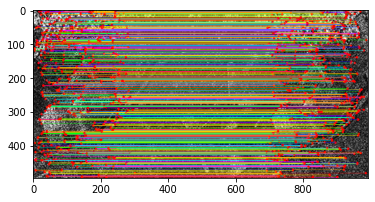

In [ ]:
 # -*- coding: utf-8 -*-
"""

@author: Administrator
"""
import __future__
import cv2
import time
import numpy as np

# import build_scale
# import find_scale_extreme
# import calc_descriptors
# import match
# import display
# import ransac
# import image_fusion
# import MI

#read image
# image to be registered
img1 = cv2.imread('path-1.png')  
img2 = cv2.imread('path-2.png') 
 # reference image

#rgb2gray
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
gray1 = gray1/255.
gray2 = gray2/255.

#initial parameter
time1 = time.time()
sigma = 2                      #initial layer scale
ratio = 2**(1/3.)               #scale ratio
Mmax = 8                       #layer number
d = 0.04
d_SH_1 = 0.8                   #Harros function threshold
d_SH_2 = 0.8                   #Harros function threshold
distRatio = 0.9
error_threshold = 1

#Creat sar-harris function
sar_harris_function_1,gradient_1,angle_1 = build_scale(gray1,sigma,Mmax,ratio,d)
sar_harris_function_2,gradient_2,angle_2 = build_scale(gray2,sigma,Mmax,ratio,d)
# time_harris_function = time.time()
# print("Create SAR HARRIS function Spend time:",time_harris_function-time1)

#Feaarure point detection
GR_key_array_1 = find_scale_extreme(sar_harris_function_1,d_SH_1,sigma,ratio,gradient_1,angle_1)
GR_key_array_2 = find_scale_extreme(sar_harris_function_2,d_SH_2,sigma,ratio,gradient_2,angle_2)
# time_point = time.time()
# print("Feature point detection:", time_point-time_harris_function)

#calculating descriptors
descriptors_1, locs_1 = calc_descriptors(gradient_1,angle_1,GR_key_array_1)
descriptors_2, locs_2 = calc_descriptors(gradient_2,angle_2,GR_key_array_2)
# time_descriptor = time.time()
# print("calculating descriptor:", time_descriptor-time_point)

#match
kp1,kp2,des1,des2 = delete_duplications(GR_key_array_1[:,0:2],GR_key_array_2[:,0:2],descriptors_1,descriptors_2)
good_kp1,good_kp2 = deep_match(kp1,kp2,des1,des2,distRatio)
better_kp1,better_kp2 = ransac(good_kp1,good_kp2,error_threshold)
solution1,rmse = least_square(better_kp1,better_kp2)

#compute MI
common1,common2 = common_region(gray1,gray2,solution1)
mi = MI(common1,common2)

#display
image_match = display(img1,img2,better_kp1,better_kp2)
plt.imshow(image_match)
plt.show()
# image_fusion1 = image_fusion(img1,img2,solution1)
# time_registration = time.time()
# print("image registration:", time_registration-time_descriptor)
# time2 = time.time()
# print("total time:",time2 - time1)

# plt.imshow(image_match)
# plt.imshow(image_fusion1),plt.show()
# cv2.imshow("image_match",image_match)
# cv2.imshow("image_fusion",image_fusion)
# cv2.waitKey(0)

In [ ]:
len(GR_key_array_1)

3755

In [ ]:
len(GR_key_array_2)

3735

In [ ]:
len(image_match[0])

992

In [ ]:
len(better_kp1)

833

In [ ]:
len(better_kp2)

833

In [ ]:
solution1

array([[ 9.9949026e-01,  4.9203634e-05,  1.8783694e+02],
       [-9.5166266e-05,  9.9985301e-01,  6.7951202e-02]], dtype=float32)